# 1  Step 1: Data Cleansing & Preprocessing

In [1]:
# install any lib that's not installed

#### Initial steps: import libs, data set import and basic count check

<B>Problem Statement:</B> 
 
Amazon, a global leader in e-commerce, wants to optimize its customer segmentation, revenue 
forecasting, and churn prediction to enhance customer retention and increase revenue. With millions 
of customers and transactions daily, Amazon collects demographic details, purchase history, and 
transaction data but faces the following challenges: 
``` 
   ✅Identifying high-value customers for targeted marketing. 
   ✅Predicting Customer Lifetime Value (CLV) to improve revenue forecasting. 
   ✅Understanding customer churn risks and improving retention strategies. 
   ✅Grouping customers into actionable segments based on behavior patterns. 
``` 
The goal of this project is to develop Machine Learning models to segment customers, predict their 
future spending, and classify them as potential churners or active customers. However, before 
building ML models, we need to clean and preprocess the data to ensure accuracy. 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
import openpyxl
import fastparquet
from pandas.plotting import (
    table, andrews_curves, autocorrelation_plot, bootstrap_plot,
    lag_plot, parallel_coordinates, radviz, scatter_matrix)
import os
from sklearn.impute import SimpleImputer

In [8]:
# Step 1: Data Cleansing & Preprocessing

In [9]:
# Step 1: Load Excel file and convert to Parquet
filepath = r"Amazon_Customer_Purchase_Data.xlsx"
df = pd.read_excel(filepath, engine='openpyxl')

In [10]:
# Convert to Parquet for efficient processing in case of large number of rows
df.to_parquet("Amazon_Customer_Purchase_Data.parquet", engine="fastparquet", index=False)

In [11]:
df.head()

,Customer_ID,Customer_Name,Age,Gender,Location,Product_Category,Product_ID,Purchase_Date,Purchase_Amount,Payment_Method,Rating,Feedback_Comments,Customer_Lifetime_Value,Loyalty_Score,Discount_Applied,Return_Status,Customer_Segment,Preferred_Shopping_Channel
0,17270,John,56.0,Other,New York,Books,674,2020-01-01 00:00:00,491.643012,Cash,NaN,NaN,3673.712747,60,No,No,Regular,In-store
1,10860,Eve,33.0,Other,Houston,Home Appliances,393,2020-01-01 01:00:00,144.326722,Cash,5.0,Good,2103.060388,29,Yes,Yes,New,In-store
2,15390,John,50.0,Female,Houston,Clothing,995,2020-01-01 02:00:00,109.301892,Bank Transfer,NaN,NaN,899.115059,92,No,No,VIP,Online
3,15191,Eve,66.0,Other,San Francisco,Electronics,405,2020-01-01 03:00:00,226.655516,Bank Transfer,2.0,Excellent,2591.137716,62,Yes,Yes,Regular,Online
4,15734,Eve,38.0,Female,New York,Toys,353,2020-01-01 04:00:00,37.851880,Bank Transfer,2.0,NaN,548.620397,80,No,Yes,Regular,Both


In [12]:
# Step 2: Basic info and data quality checks
missing_values = df.isnull().sum().sort_values(ascending=False).head(7)
duplicates_count = df.duplicated(subset=['Customer_ID', 'Purchase_Date']).sum()
data_types = df.dtypes
print(missing_values)
print(f"Total Duplicate counts = {duplicates_count}")
print(data_types)

Feedback_Comments          901
Purchase_Amount            200
Customer_Lifetime_Value    200
Rating                     140
Age                        100
Customer_Name              100
Customer_ID                  0
dtype: int64
Total Duplicate counts = 0
Customer_ID                            int64
Customer_Name                         object
Age                                  float64
Gender                                object
Location                              object
Product_Category                      object
Product_ID                             int64
Purchase_Date                 datetime64[ns]
Purchase_Amount                      float64
Payment_Method                        object
Rating                               float64
Feedback_Comments                     object
Customer_Lifetime_Value              float64
Loyalty_Score                          int64
Discount_Applied                      object
Return_Status                         object
Customer_Segment       

In [7]:
# Due to missing values for columns like Customer name and age, we can get that from customer id
# df['Customer_Name'] = df.groupby('Customer_ID')['Customer_Name'].transform('first')
# df['Age'] = df.groupby('Customer_ID')['Age'].transform('first')
# # df['Age'] = df.groupby('Customer_Name')['Age'].transform('first')


In [13]:
# Seprate Data frame for nan and non nan values in customer name:
df_nan = df[df['Customer_Name'].isna()].copy()
df_not_nan = df[df['Customer_Name'].notna()].copy()
print(df_nan.shape,df_not_nan.shape)

(100, 18) (1900, 18)


In [9]:
# Code is giving more number of nan by replacing existing values. Not recommended.
# df_not_nan['combined'] = df_not_nan['Customer_ID'].astype(str) + '_' + df['Customer_Name'].astype(str)
# df['Age'] = df_not_nan.groupby('combined')['Age'].transform('first')

In [14]:
import pandas as pd
import numpy as np
# Let's start with df for name
df['Customer_Name'] = df.groupby('Customer_ID')['Customer_Name'].transform(lambda x:x.ffill().bfill() if x.notna().any() else x)
df['Customer_Name'] = df['Customer_Name'].fillna('John Jane Doe')
df.isna().sum()

Customer_ID                     0
Customer_Name                   0
Age                           100
Gender                          0
Location                        0
Product_Category                0
Product_ID                      0
Purchase_Date                   0
Purchase_Amount               200
Payment_Method                  0
Rating                        140
Feedback_Comments             901
Customer_Lifetime_Value       200
Loyalty_Score                   0
Discount_Applied                0
Return_Status                   0
Customer_Segment                0
Preferred_Shopping_Channel      0
dtype: int64

In [15]:
df['id_name_meerge'] = df['Customer_ID'].astype(str)+ '_' + df['Customer_Name'].astype(str)
df['id_name_meerge'].describe()

count          2000
unique         1946
top       14146_Eve
freq              3
Name: id_name_meerge, dtype: object

In [16]:
# Now use the merged features to get the ages as well:
df['Age'] = df.groupby('id_name_meerge')['Age'].transform(lambda x: x.ffill().bfill() if x.notna().any() else x)
df['Age'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2000 entries, 0 to 1999
Series name: Age
Non-Null Count  Dtype  
--------------  -----  
1904 non-null   float64
dtypes: float64(1)
memory usage: 15.8 KB


In [17]:
df.isna().sum()

Customer_ID                     0
Customer_Name                   0
Age                            96
Gender                          0
Location                        0
Product_Category                0
Product_ID                      0
Purchase_Date                   0
Purchase_Amount               200
Payment_Method                  0
Rating                        140
Feedback_Comments             901
Customer_Lifetime_Value       200
Loyalty_Score                   0
Discount_Applied                0
Return_Status                   0
Customer_Segment                0
Preferred_Shopping_Channel      0
id_name_meerge                  0
dtype: int64

In [18]:
# We don't have blanks in the product ID.
a1 = df.groupby('Product_ID')['Purchase_Amount'].transform(lambda p: p.ffill().bfill() if p.notna().any() else 0)

In [19]:
print(df['Purchase_Amount'].mean(),np.mean(a1.tolist()))
# Since the difference is small we can use the mean method to fill na in the main df.

257.954369978958 253.64459020726446


In [113]:
df['Purchase_Amount'] = df.groupby('Product_ID')['Purchase_Amount'].transform(lambda p: p.ffill().bfill() if p.notna().any() else 0)
df.isna().sum().sort_values(ascending=False)

Feedback_Comments             901
Customer_Lifetime_Value       200
Rating                        140
Age                            96
Customer_ID                     0
Location                        0
Gender                          0
Customer_Name                   0
Product_Category                0
Purchase_Amount                 0
Purchase_Date                   0
Product_ID                      0
Payment_Method                  0
Loyalty_Score                   0
Discount_Applied                0
Return_Status                   0
Customer_Segment                0
Preferred_Shopping_Channel      0
id_name_meerge                  0
CID_PID_CH                      0
CID_PID                         0
dtype: int64

In [70]:
df['CID_PID'] = df['Product_ID'].astype(str)+'_'+df['Customer_Name'].astype(str)

In [73]:
df2 = df[['Customer_ID','Product_ID','Preferred_Shopping_Channel','CID_PID','Rating']].copy()

In [74]:
df2.isna().sum()

Customer_ID                     0
Product_ID                      0
Preferred_Shopping_Channel      0
CID_PID                         0
Rating                        140
dtype: int64

In [75]:
df2['Rating'] = df2['Rating'].fillna(df2.groupby('CID_PID')['Rating'].median())

In [76]:
df2.isna().sum()

Customer_ID                     0
Product_ID                      0
Preferred_Shopping_Channel      0
CID_PID                         0
Rating                        140
dtype: int64

In [80]:
num_df = df.select_dtypes(include=['int64','float'])
obj_df = df.select_dtypes(include=['object'])

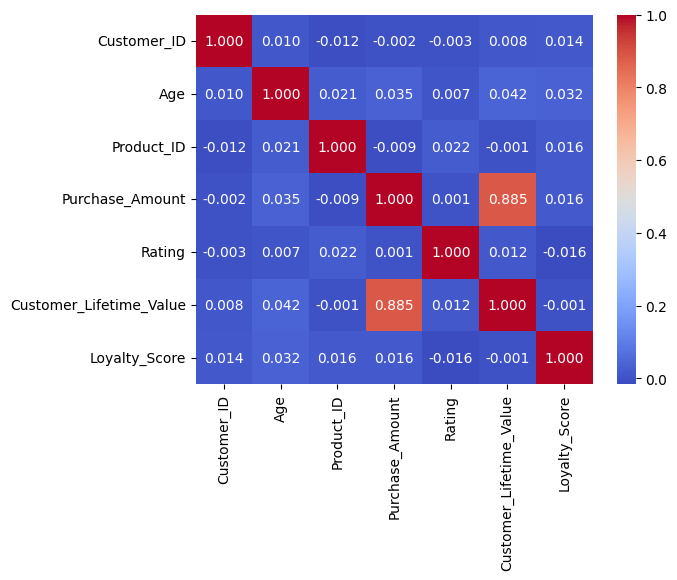

In [112]:
# corr_df = num_df.corr().reset_index()
# sns.heatmap(corr_df,annot=True,cmap='coolwarm',fmt=".2f")

corr_matrix = num_df.corr(method='spearman')
sns.heatmap(corr_matrix,cmap='coolwarm',annot=True,fmt=".3f")
plt.savefig("num_df_corr_matrix.png")
plt.show()

##### Correlation with Rating and Product_ID

In [119]:
df['Customer_Lifetime_Value'].isna().sum()

np.int64(200)

In [120]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis


kurt_fisher = kurtosis(df['Customer_Lifetime_Value'].notna(), fisher=True, bias=False)
kurt_pearson = kurtosis(df['Customer_Lifetime_Value'].notna(), fisher=False, bias=False)

print(kurt_fisher,kurt_pearson)

5.126917937800929 8.126917937800929


Excess kurtosis (Fisher): -0.4870
Kurtosis (Pearson):      2.5130
Skewness:                0.5630

Percentiles:
 0.50    2305.364380
0.75    3651.162484
0.90    5071.155008
0.95    5713.216917
0.99    6628.581441
Name: Customer_Lifetime_Value, dtype: float64

Mean vs Median: 2566.7240256998307 vs 2305.3643795382754
IQR: 2432.3543580682485

Top decile share of total CLV: 22.59%


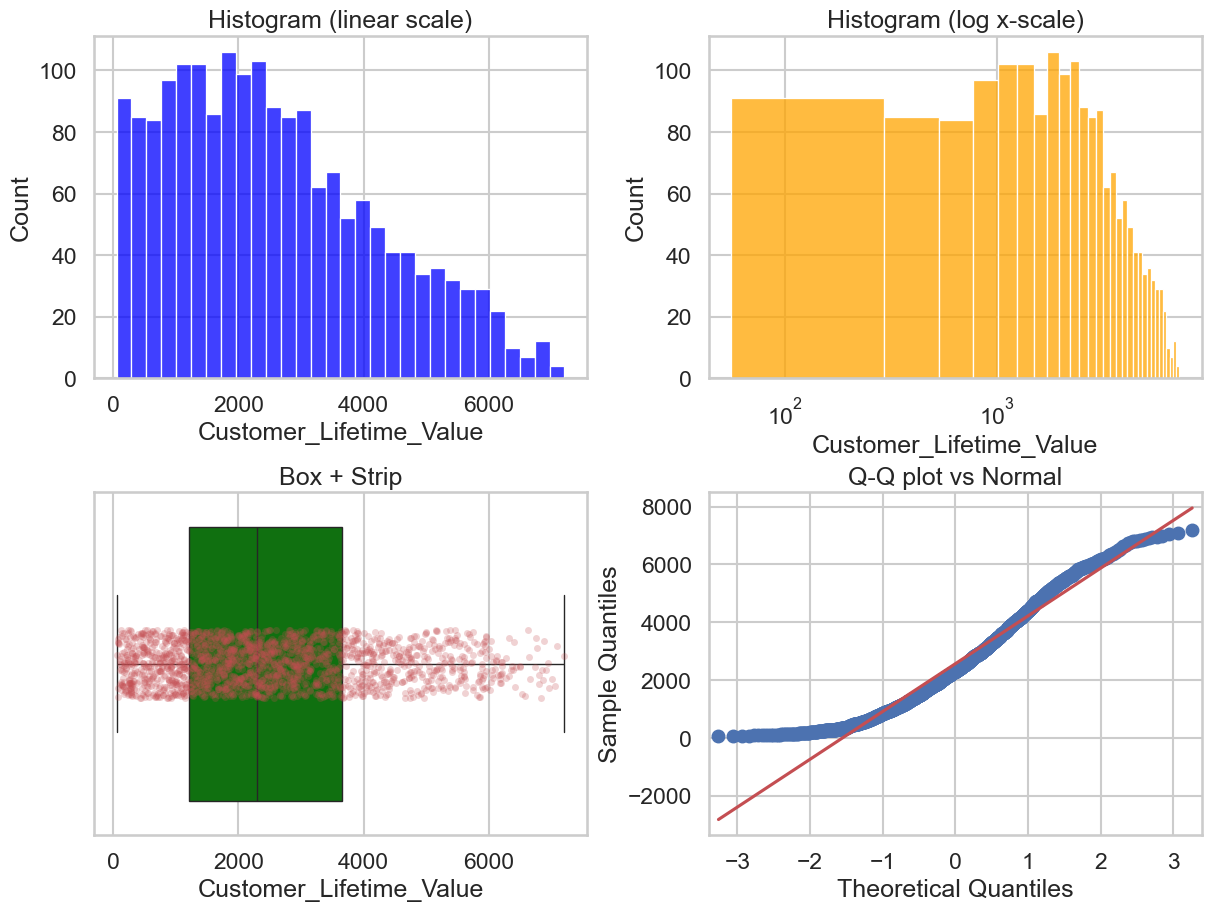

In [131]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

s = df['Customer_Lifetime_Value'].dropna()

# Kurtosis (should match your values if computed similarly)
k_fisher = stats.kurtosis(s, fisher=True, bias=False)   # excess kurtosis
k_pearson = stats.kurtosis(s, fisher=False, bias=False) # = excess + 3
skewness = stats.skew(s, bias=False)

print(f"Excess kurtosis (Fisher): {k_fisher:.4f}")
print(f"Kurtosis (Pearson):      {k_pearson:.4f}")
print(f"Skewness:                {skewness:.4f}")

# Percentiles & robust stats
q = s.quantile([0.5, 0.75, 0.9, 0.95, 0.99])
print("\nPercentiles:\n", q)
print("\nMean vs Median:", s.mean(), "vs", s.median())
print("IQR:", s.quantile(0.75) - s.quantile(0.25))

# Top-decile share of total CLV
decile_cut = s.quantile(0.9)
top_decile_share = s[s >= decile_cut].sum() / s.sum()
print(f"\nTop decile share of total CLV: {top_decile_share:.2%}")

# Visuals: histogram (linear + log), boxplot, ECDF, Q-Q plot
sns.set_theme(style="whitegrid", context="talk")
fig, axes = plt.subplots(2, 2, figsize=(12, 9), layout='constrained')


# Histogram – linear
sns.histplot(s, bins=30, ax=axes[0,0], color='blue')
axes[0,0].set_title("Histogram (linear scale)")

# Histogram – log-scaled x (better for heavy right tails)
sns.histplot(s, bins=30, ax=axes[0,1], color="orange")
axes[0,1].set_xscale('log')
axes[0,1].set_title("Histogram (log x-scale)")

# Boxplot + strip
sns.boxplot(x=s, ax=axes[1,0], color="green")
sns.stripplot(x=s, ax=axes[1,0], color="r", alpha=0.25)
axes[1,0].set_title("Box + Strip")
# Q-Q plot vs normal (heavy tails show up as deviations)
import statsmodels.api as sm
sm.qqplot(s, line='s', ax=axes[1,1])
axes[1,1].set_title("Q-Q plot vs Normal")
plt.savefig("CLV_Skewness_plots.png")
plt.show()

In [141]:
#    Data Formatting & Type Correction 
# • Convert Purchase_Date to datetime format.

# Convert Purchase_Date to datetime format
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], format='%Y-%m-%d',errors='coerce').dt.date

In [142]:
df['Purchase_Date'].head()

0    2020-01-01
1    2020-01-01
2    2020-01-01
3    2020-01-01
4    2020-01-01
Name: Purchase_Date, dtype: object

##### • Standardize categorical values (e.g., Gender: Male, Female, Other).

In [143]:
# Standardize categorical values (e.g., Gender: Male, Female, Other).
if 'Gender' in df.columns:
    df['Gender'] = df['Gender'].str.strip().str.title()  # Normalize case
    # Map variations to standard values
    gender_map = {
        'Male': 'Male',
        'Female': 'Female',
        'Other': 'Other'
    }
    df['Gender'] = df['Gender'].map(gender_map).fillna('Other')

##### * Ensure consistent data types (integers for numeric fields, categorical encoding for non numeric)

In [144]:
numeric_cols = ['Customer_ID', 'Age', 'Product_ID', 'Purchase_Amount', 'Rating', 'Customer_Lifetime_Value', 'Loyalty_Score']
for col in numeric_cols:
    if col in df.columns:
        # If column should be integer (IDs, Loyalty_Score), cast to int if no NaN
        if col in ['Customer_ID', 'Product_ID', 'Loyalty_Score']:
            df[col] = df[col].astype('int64')
        else:
            df[col] = df[col].astype('float64')

# Convert categorical columns to category dtype
categorical_cols = ['Customer_Name', 'Gender', 'Location', 'Product_Category', 'Payment_Method', 'Discount_Applied', 'Return_Status', 'Customer_Segment', 'Preferred_Shopping_Channel']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

In [145]:
col_names = df.columns.tolist()
print(col_names)

['Customer_ID', 'Customer_Name', 'Age', 'Gender', 'Location', 'Product_Category', 'Product_ID', 'Purchase_Date', 'Purchase_Amount', 'Payment_Method', 'Rating', 'Feedback_Comments', 'Customer_Lifetime_Value', 'Loyalty_Score', 'Discount_Applied', 'Return_Status', 'Customer_Segment', 'Preferred_Shopping_Channel', 'id_name_meerge', 'CID_PID_CH', 'CID_PID']


In [6]:
# ['Customer_ID'-> num, 'Customer_Name'-> cat, 'Age'-> num, 'Gender'-cat, 'Location',-cat 
#  'Product_Category'-cat, 'Product_ID'-int64,
#  'Purchase_Date'--date, 'Purchase_Amount'- num, 'Payment_Method',- cat
#  'Rating'-num, 'Feedback_Comments'-cat,'Customer_Lifetime_Value'-num, 'Loyalty_Score'-num, 
#  'Discount_Applied'-cat, 'Return_Status'-cat, 'Customer_Segment'cat, 'Preferred_Shopping_Channel'-cat]

# columns by data types

num_cols = ['Age', 'Purchase_Amount', 'Rating', 'Customer_Lifetime_Value','Loyality_Score']
cat_cols = ['Payment_Method', 'Customer_Name', 'Location', 'Gender',
            'Product_Category', 'Discount_Applied', 'Return_Status',
            'Customer_Segment', 'Preferred_Shopping_Channel']

num_cols = [c for c in num_cols if c in df.columns]
cat_cols = [c for c in cat_cols if c in df.columns]

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')  # mode

df_imputed = df.copy()
if num_cols:
    df_imputed[num_cols] = num_imputer.fit_transform(df_imputed[num_cols])
if cat_cols:
    df_imputed[cat_cols] = cat_imputer.fit_transform(df_imputed[cat_cols])

print("Missing after imputation (targets):\n",
      df_imputed[num_cols + cat_cols].isnull().sum())

Missing after imputation (targets):
 Age                           0
Purchase_Amount               0
Rating                        0
Customer_Lifetime_Value       0
Payment_Method                0
Customer_Name                 0
Location                      0
Gender                        0
Product_Category              0
Discount_Applied              0
Return_Status                 0
Customer_Segment              0
Preferred_Shopping_Channel    0
dtype: int64


In [10]:
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Customer_ID                 2000 non-null   int64         
 1   Customer_Name               2000 non-null   object        
 2   Age                         2000 non-null   float64       
 3   Gender                      2000 non-null   object        
 4   Location                    2000 non-null   object        
 5   Product_Category            2000 non-null   object        
 6   Product_ID                  2000 non-null   int64         
 7   Purchase_Date               2000 non-null   datetime64[ns]
 8   Purchase_Amount             2000 non-null   float64       
 9   Payment_Method              2000 non-null   object        
 10  Rating                      2000 non-null   float64       
 11  Feedback_Comments           1099 non-null   object      

In [146]:
ff_df = df.sort_values(by='Customer_ID',ascending=True).fillna(method='ffill').copy()
bf_df = df.sort_values(by='Customer_ID',ascending=True).fillna(method='bfill').copy()

C:\Users\SMangal\AppData\Local\Temp\ipykernel_2244\545767764.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ff_df = df.sort_values(by='Customer_ID',ascending=True).fillna(method='ffill').copy()
C:\Users\SMangal\AppData\Local\Temp\ipykernel_2244\545767764.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bf_df = df.sort_values(by='Customer_ID',ascending=True).fillna(method='bfill').copy()


In [147]:
ff_df

,Customer_ID,Customer_Name,Age,Gender,Location,Product_Category,Product_ID,Purchase_Date,Purchase_Amount,Payment_Method,...,Feedback_Comments,Customer_Lifetime_Value,Loyalty_Score,Discount_Applied,Return_Status,Customer_Segment,Preferred_Shopping_Channel,id_name_meerge,CID_PID_CH,CID_PID
1598,10001,Eve,69.0,Other,Chicago,Books,435,2020-03-07,124.156384,PayPal,...,NaN,810.275088,38,No,Yes,New,In-store,10001_Eve,10001_435_In-store,435_Eve
1695,10001,Charlie,20.0,Male,Los Angeles,Clothing,893,2020-03-11,20.858172,Credit Card,...,NaN,161.377968,6,No,No,New,In-store,10001_Charlie,10001_893_In-store,893_Charlie
378,10004,John Jane Doe,40.0,Female,New York,Electronics,998,2020-01-16,183.238939,Cash,...,NaN,161.377968,48,No,No,Regular,Online,10004_John Jane Doe,10004_998_Online,998_John Jane Doe
862,10005,Eve,32.0,Other,Chicago,Toys,581,2020-02-05,453.168418,Cash,...,Good,4522.924674,94,No,No,VIP,Both,10005_Eve,10005_581_Both,581_Eve
656,10009,Alice,66.0,Female,New York,Toys,683,2020-01-28,188.434881,Credit Card,...,Good,2741.561300,10,Yes,No,New,Online,10009_Alice,10009_683_Online,683_Alice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,19986,John,61.0,Other,Chicago,Books,237,2020-01-09,50.294279,Bank Transfer,...,Bad,335.722273,74,Yes,No,Regular,In-store,19986_John,19986_237_In-store,237_John
1682,19989,John,64.0,Other,Houston,Books,403,2020-03-11,407.000866,Cash,...,Bad,2273.350337,95,No,No,VIP,Online,19989_John,19989_403_Online,403_John
1788,19991,John,62.0,Female,San Francisco,Home Appliances,210,2020-03-15,406.460576,Credit Card,...,Bad,3866.475839,31,No,No,New,In-store,19991_John,19991_210_In-store,210_John
1325,19996,John,21.0,Male,San Francisco,Electronics,323,2020-02-25,277.289193,Cash,...,Average,3900.518400,2,No,No,New,Online,19996_John,19996_323_Online,323_John


In [148]:
bf_df

,Customer_ID,Customer_Name,Age,Gender,Location,Product_Category,Product_ID,Purchase_Date,Purchase_Amount,Payment_Method,...,Feedback_Comments,Customer_Lifetime_Value,Loyalty_Score,Discount_Applied,Return_Status,Customer_Segment,Preferred_Shopping_Channel,id_name_meerge,CID_PID_CH,CID_PID
1598,10001,Eve,69.0,Other,Chicago,Books,435,2020-03-07,124.156384,PayPal,...,Good,810.275088,38,No,Yes,New,In-store,10001_Eve,10001_435_In-store,435_Eve
1695,10001,Charlie,20.0,Male,Los Angeles,Clothing,893,2020-03-11,20.858172,Credit Card,...,Good,161.377968,6,No,No,New,In-store,10001_Charlie,10001_893_In-store,893_Charlie
378,10004,John Jane Doe,40.0,Female,New York,Electronics,998,2020-01-16,183.238939,Cash,...,Good,4522.924674,48,No,No,Regular,Online,10004_John Jane Doe,10004_998_Online,998_John Jane Doe
862,10005,Eve,32.0,Other,Chicago,Toys,581,2020-02-05,453.168418,Cash,...,Good,4522.924674,94,No,No,VIP,Both,10005_Eve,10005_581_Both,581_Eve
656,10009,Alice,66.0,Female,New York,Toys,683,2020-01-28,188.434881,Credit Card,...,Average,2741.561300,10,Yes,No,New,Online,10009_Alice,10009_683_Online,683_Alice
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,19986,John,61.0,Other,Chicago,Books,237,2020-01-09,50.294279,Bank Transfer,...,Average,2273.350337,74,Yes,No,Regular,In-store,19986_John,19986_237_In-store,237_John
1682,19989,John,64.0,Other,Houston,Books,403,2020-03-11,407.000866,Cash,...,Average,2273.350337,95,No,No,VIP,Online,19989_John,19989_403_Online,403_John
1788,19991,John,62.0,Female,San Francisco,Home Appliances,210,2020-03-15,406.460576,Credit Card,...,Average,3866.475839,31,No,No,New,In-store,19991_John,19991_210_In-store,210_John
1325,19996,John,21.0,Male,San Francisco,Electronics,323,2020-02-25,277.289193,Cash,...,Average,3900.518400,2,No,No,New,Online,19996_John,19996_323_Online,323_John


In [63]:
# df.isna().sum().sort_values(ascending=False)
ff_df['Feedback_Comments'].replace(np.nan,'No Comments',inplace = True)
bf_df['Feedback_Comments'].replace(np.nan,'No Comments',inplace = True)
# ff_df.isna().sum().sort_values(ascending=False)
# bf_df.isna().sum().sort_values(ascending=False)

C:\Users\SMangal\AppData\Local\Temp\ipykernel_6184\1600053570.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ff_df['Feedback_Comments'].replace(np.nan,'No Comments',inplace = True)
C:\Users\SMangal\AppData\Local\Temp\ipykernel_6184\1600053570.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [72]:
# check for ffill and bfill differences

import pandas as pd
diff = ff_df.compare(bf_df,align_axis=0,keep_shape=True,keep_equal=False)
diff.desc

,Customer_ID,Age,Product_ID,Purchase_Date,Purchase_Amount,Rating,Customer_Lifetime_Value,Loyalty_Score
count,0.0,196.000000,0.0,0,400.000000,244.000000,400.000000,0.0
mean,NaN,43.224490,NaN,NaT,262.073541,2.971311,2541.887739,NaN
min,NaN,18.000000,NaN,NaT,11.049050,1.000000,96.945555,NaN
25%,NaN,30.750000,NaN,NaT,123.517040,2.000000,1149.418592,NaN
50%,NaN,42.000000,NaN,NaT,264.080335,3.000000,2277.893826,NaN
75%,NaN,57.000000,NaN,NaT,395.939846,4.000000,3506.185128,NaN
max,NaN,69.000000,NaN,NaT,499.319599,5.000000,6963.530972,NaN
std,NaN,15.290708,NaN,NaN,150.446271,1.421179,1692.946566,NaN


In [6]:
# Step 3: Descriptive statistics
numeric_stats = df.describe()
categorical_stats = df.describe(include=['object'])
int_stats = df.describe(include=['int64'])
float_stats = df.describe(include=['float64'])
dt_stats = df.describe(include=['datetime64[ns]'])

## use same stat after ff and bfill

numeric_stats = df.describe()
categorical_stats = df.describe(include=['object'])
int_stats = df.describe(include=['int64'])
float_stats = df.describe(include=['float64'])
dt_stats = df.describe(include=['datetime64[ns]'])

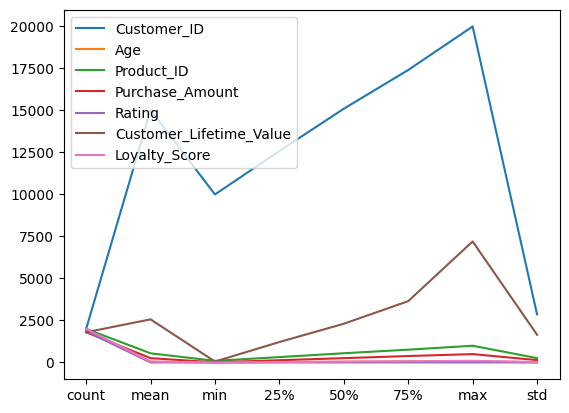

In [7]:
numeric_stats.plot(kind = 'line')
plt.show()

In [8]:
print(categorical_stats)

       Customer_Name  Gender  Location Product_Category Payment_Method  \
count           1900    2000      2000             2000           2000   
unique             5       3         5                5              4   
top              Eve  Female  New York             Toys    Credit Card   
freq             398     687       434              437            509   

       Feedback_Comments Discount_Applied Return_Status Customer_Segment  \
count               1099             2000          2000             2000   
unique                 4                2             2                3   
top                 Good               No            No          Regular   
freq                 290             1397          1588              824   

       Preferred_Shopping_Channel  
count                        2000  
unique                          3  
top                        Online  
freq                          999  


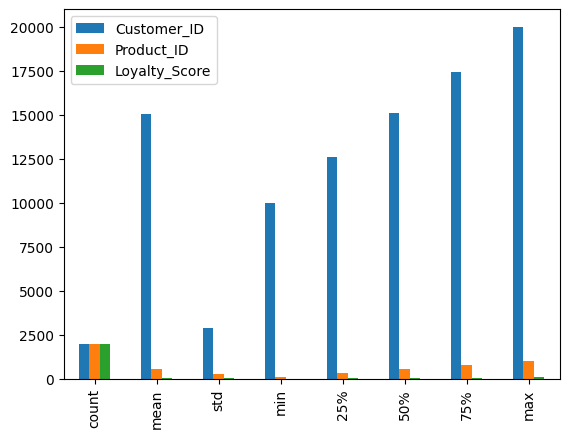

In [9]:
int_stats.plot(kind = 'bar')
plt.show()

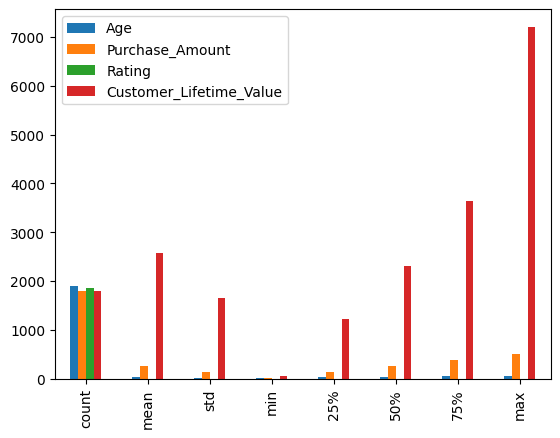

In [10]:
float_stats.plot(kind = 'bar')
plt.show()

In [11]:
print(dt_stats)

                       Purchase_Date
count                           2000
mean   2020-02-11 15:29:59.999999744
min              2020-01-01 00:00:00
25%              2020-01-21 19:45:00
50%              2020-02-11 15:30:00
75%              2020-03-03 11:15:00
max              2020-03-24 07:00:00


In [12]:
# Step 4: Outlier detection using z-score for Purchase_Amount and Customer_Lifetime_Value
numeric_cols = ['Purchase_Amount', 'Customer_Lifetime_Value']
z_scores = np.abs(stats.zscore(df[numeric_cols].fillna(df[numeric_cols].mean())))
outliers = (z_scores > 3).sum(axis=0)
print(z_scores[:][:])
print(outliers)

[[1.73254136 0.70611909]
 [0.84242263 0.29575888]
 [1.10209279 1.06372405]
 ...
 [0.33040796 0.89999299]
 [1.29667034 0.90018947]
 [1.64126496 1.39414722]]
[0 0]


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

sns.pairplot(df)
# fig, ax = plt.subplot(figsize=(10,10))
plt.title("PairPlot")
plt.savefig("pairplot.pdf",dpi=600)
plt.show()

```
- plot (describe above, used for `Series.plot` and `DataFrame.plot`)
- hist_series and hist_frame (for `Series.hist` and `DataFrame.hist`)
- boxplot (`pandas.plotting.boxplot(df)` equivalent to `DataFrame.boxplot`)
- boxplot_frame and boxplot_frame_groupby
- register and deregister (register converters for the tick formats)
- Plots not called as `Series` and `DataFrame` methods:
  - table
  - andrews_curves
  - autocorrelation_plot
  - bootstrap_plot
  - lag_plot
  - parallel_coordinates
  - radviz
  - scatter_matrix
  
```

In [43]:
df.isna().sum()

Customer_ID                     0
Customer_Name                 100
Age                           100
Gender                          0
Location                        0
Product_Category                0
Product_ID                      0
Purchase_Date                   0
Purchase_Amount               200
Payment_Method                  0
Rating                        140
Feedback_Comments             901
Customer_Lifetime_Value       200
Loyalty_Score                   0
Discount_Applied                0
Return_Status                   0
Customer_Segment                0
Preferred_Shopping_Channel      0
dtype: int64

In [13]:
# Step 5: Distribution analysis for key features
fig_age = px.histogram(df, x='Age', nbins=20, title='Age Distribution')
fig_age.write_json('age_distribution.json')
fig_age.write_image('age_distribution.png')

fig_purchase = px.histogram(df, x='Purchase_Amount', nbins=30, title='Purchase Amount Distribution')
fig_purchase.write_json('purchase_amount_distribution.json')
fig_purchase.write_image('purchase_amount_distribution.png')

fig_rating = px.histogram(df, x='Rating', nbins=5, title='Rating Distribution')
fig_rating.write_json('rating_distribution.json')
fig_rating.write_image('rating_distribution.png')

fig_loyalty = px.histogram(df, x='Loyalty_Score', nbins=20, title='Loyalty Score Distribution')
fig_loyalty.write_json('loyalty_score_distribution.json')
fig_loyalty.write_image('loyalty_score_distribution.png')

In [82]:
# Step 6: Correlation analysis
corr_matrix = df[numeric_cols + ['Age', 'Loyalty_Score']].corr().plot(kind='heatmap')

NameError: name 'numeric_cols' is not defined

In [ ]:
# Step 7: Extra insights
# Top product categories
top_categories = df['Product_Category'].value_counts().head(5)

# Most common payment methods
top_payment_methods = df['Payment_Method'].value_counts().head(5)

# Average purchase amount by location
avg_purchase_by_location = df.groupby('Location')['Purchase_Amount'].mean().sort_values(ascending=False)

# Customer segment distribution
segment_distribution = df['Customer_Segment'].value_counts()

# Save cleaned dataset as .pkl for modeling
df.to_pickle("Amazon_Customer_Purchase_Data_cleaned.pkl")

# Print insights
print("Missing Values per Column:\n", missing_values)
print("\nNumber of Duplicate Records:", duplicates_count)
print("\nData Types:\n", data_types)
print("\nNumeric Stats:\n", numeric_stats)
print("\nCategorical Stats:\n", categorical_stats)
print("\nOutliers Detected (z-score > 3):\n", outliers)
print("\nCorrelation Matrix:\n", corr_matrix)
print("\nTop 5 Product Categories:\n", top_categories)
print("\nTop 5 Payment Methods:\n", top_payment_methods)
print("\nAverage Purchase Amount by Location:\n", avg_purchase_by_location)
print("\nCustomer Segment Distribution:\n", segment_distribution)

In [75]:
# import pandas as pd
# import numpy as np
# import matplotlib
# matplotlib.use('Agg')
# import matplotlib.pyplot as plt
# from pandas.plotting import scatter_matrix, parallel_coordinates, andrews_curves, radviz, lag_plot, autocorrelation_plot

# # Load from parquet if exists; else from Excel
# import os
# if os.path.exists('Amazon_Customer_Purchase_Data.parquet'):
#     df = pd.read_parquet('Amazon_Customer_Purchase_Data.parquet')
# else:
#     df = pd.read_excel('Amazon_Customer_Purchase_Data.xlsx', engine='openpyxl')

# # Prepare data: ensure correct dtypes
# # Convert Purchase_Date to datetime if not
# if not pd.api.types.is_datetime64_any_dtype(df['Purchase_Date']):
#     df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')

# # Select numeric columns for plotting
# numeric_cols = ['Age','Purchase_Amount','Rating','Customer_Lifetime_Value','Loyalty_Score']
# available_numeric = [c for c in numeric_cols if c in df.columns]

# # Drop rows with missing values in available_numeric for clean plotting
# df_num = df[available_numeric].dropna()

# # 1) Scatter Matrix (relationships among numeric features)
# fig1 = plt.figure(figsize=(10,10))
# axarr = scatter_matrix(df_num, alpha=0.4, diagonal='hist', figsize=(10,10))
# plt.tight_layout()
# fig1.savefig('scatter_matrix.png', dpi=200)
# plt.close(fig1)

# # 2) Parallel Coordinates (numeric features by Customer_Segment)
# class_col = 'Customer_Segment'
# cols_for_pc = available_numeric.copy()
# if class_col in df.columns and len(cols_for_pc) >= 2:
#     # Restrict to a manageable sample per class to avoid clutter
#     df_pc = df[cols_for_pc + [class_col]].dropna()
#     # Keep top classes by frequency
#     top_classes = df_pc[class_col].value_counts().index.tolist()
#     df_pc = df_pc[df_pc[class_col].isin(top_classes)]

#     plt.figure(figsize=(12,6))
#     parallel_coordinates(df_pc, class_column=class_col, colormap='viridis')
#     plt.title('Parallel Coordinates by Customer_Segment')
#     plt.tight_layout()
#     plt.savefig('parallel_coordinates.png', dpi=200)
#     plt.close()

# # 3) Andrews Curves (numeric features by Customer_Segment)
# if class_col in df.columns and len(cols_for_pc) >= 2:
#     df_ac = df[cols_for_pc + [class_col]].dropna()
#     plt.figure(figsize=(12,6))
#     andrews_curves(df_ac, class_col)
#     plt.title('Andrews Curves by Customer_Segment')
#     plt.tight_layout()
#     plt.savefig('andrews_curves.png', dpi=200)
#     plt.close()

# # 4) RadViz (numeric features by Customer_Segment)
# if class_col in df.columns and len(cols_for_pc) >= 2:
#     df_rv = df[cols_for_pc + [class_col]].dropna()
#     plt.figure(figsize=(8,8))
#     radviz(df_rv, class_col, colormap='coolwarm')
#     plt.title('RadViz by Customer_Segment')
#     plt.tight_layout()
#     plt.savefig('radviz.png', dpi=200)
#     plt.close()

# # 5) Lag Plot for Purchase_Amount time behavior
# if 'Purchase_Amount' in df.columns:
#     s = df.sort_values('Purchase_Date')['Purchase_Amount']
#     s = s.dropna()
#     plt.figure(figsize=(6,6))
#     lag_plot(s)
#     plt.title('Lag Plot: Purchase_Amount')
#     plt.tight_layout()
#     plt.savefig('lag_plot_purchase_amount.png', dpi=200)
#     plt.close()

# # 6) Autocorrelation Plot for Purchase_Amount
# if 'Purchase_Amount' in df.columns:
#     s = df.sort_values('Purchase_Date')['Purchase_Amount']
#     s = s.dropna()
#     plt.figure(figsize=(8,4))
#     autocorrelation_plot(s)
#     plt.title('Autocorrelation: Purchase_Amount')
#     plt.tight_layout()
#     plt.savefig('autocorrelation_purchase_amount.png', dpi=200)
#     plt.close()

# # 7) Scatter Matrix by Payment Method (optional colored points) - pandas doesn't color; we provide standard scatter_matrix.

# print('Generated plots for pd.plotting features on available columns.')

Generated plots for pd.plotting features on available columns.
